<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 9 -  Convoluções
**Nome: Felipe de Lima Peressim**

**Numero Usp: 11823558**









______________




O objetivo desta lista é fazer com que vocês se familiarizem com redes convolucionais, vocês ja tiveram um contato breve com essa arquitetura algumas listas atrás mas dessa vez vocês cuidarão sozinhos da implementação e deverão tomar medidas para evitar overfitting. Novamente, as questões 1 2 e 3 podem ser copiadas de listas anteriores.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dense, Dropout, Input, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.3.1'

### Importando os dados como um dataframe

Para esta lista nós utilizaremos o dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [3]:
b2wCorpus = pd.read_csv("/home/felipe/Desktop/b2w-reviews01/B2W-Reviews01.csv", sep=';', usecols=["review_text", "recommend_to_a_friend"])
b2wCorpus.head()

,recommend_to_a_friend,review_text
0,Yes,Estou contente com a compra entrega rápida o ú...
1,Yes,"Por apenas R$1994.20,eu consegui comprar esse ..."
2,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4,Yes,"A entrega foi no prazo, as americanas estão de..."


In [4]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar. 
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

In [5]:
b2wCorpus["reviewer_gender"].value_counts()

M                                                                         5033
F                                                                         4624
                                                                             1
1970                                                                         1
Ocorrência: Z-Devolução Em Andamento Ao Cd de São Paulo 22/12/17 16:12       1
Name: reviewer_gender, dtype: int64

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". 

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [4]:
b2wCorpus['recommend_to_a_friend'] = b2wCorpus['recommend_to_a_friend'].apply(lambda word : 1 if str(word).lower() == 'yes' else 0)
x = b2wCorpus['review_text'].values.astype('str')
y = b2wCorpus['recommend_to_a_friend'].values

In [5]:
b2wCorpus['review_text'].values

array(['Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.',
       'Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.',
       'SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS.  COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO,  +/- 50 MINUTOS.  NESSA PANELA  É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS.    EU RECOMENDO.',
       ..., 'Chegou antes do prazo previsto e corresponde ao anúncio',
       'Material fraco, poderia ser melhor. Ficou devendo na minha opinião.',
       'Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.'],
      dtype='<U4548')

### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

### Tokenizando

Para alimentarmos os reviews a camada de embedding nós precisamos quebrar cada review em uma serie de tokens. Existem diversas maneiras de se realizar isso e poderiamos até mesmo usar outras bibliotecas como o spaCy. 

Por exemplo, o objeto [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) oferece um método `tokenize` para quebrar as palavras em tokens individuais ao mesmo tempo que filtra caracteres indesejados (por default os caracteres filtrados são: !"#$\%&()*+,-./:;<=>?@[\\]^_\`{|}~\t\n).


Para essa lista utilizaremos a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) para automaticamente passar os reviews para caixa-baixa, extrair caracteres especiais e tokenizar as palavras de maneira a serem passadas para a camada de embedding. Ao tornarmos a etapa de tokenização uma camada de rede neural nós podemos incluir esse processamento dos reviews no proprio modelo.


## <font color='blue'>Questão 3 </font>
Utilizando a camada `TextVectorization` tokenize os inputs.
Declare a camada e então chame a função `adapt()` para adequar o seu vocabulário aos reviews.

Não se esqueça de se certificar que todas os reviews tenham o mesmo comprimento, seja por meio do uso de padding, truncamento ou uma mistura dos dois. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

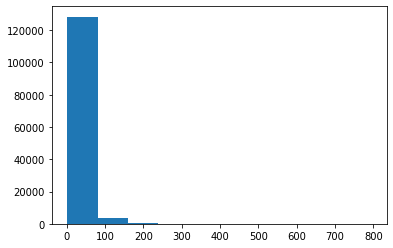

In [7]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [8]:
SEQUENCE_MAXLEN = 50
textVecLayer = TextVectorization(output_mode="int", pad_to_max_tokens=False, output_sequence_length=SEQUENCE_MAXLEN)                                                              
textVecLayer.adapt(x_train)
vocab_size = len(textVecLayer.get_vocabulary())
MAX_NB_WORDS = vocab_size
EMBEDDING_DIM = 50

In [9]:
print(MAX_NB_WORDS)

59181


### Montando o modelo

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

##  <font color='blue'>Questão 4 </font>

Defina seu modelo.

Como analise de sentimentos pode ser visto como um problema de classificação, é interessante também registrar algumas métricas como acurácia `metrics=["acc"]` .

Seu modelo deve começar com a seguinte estrutura:
 - Camada de Input
 - Camada de Tokenização
 - Camada de Embedding
 
Já definimos as camadas seguintes da rede por você.
 
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.


In [10]:
# Seu código aqui
model = Sequential()
model.add(Input(shape=(1, ), dtype=tf.string))
model.add(textVecLayer)
model.add(Embedding(MAX_NB_WORDS + 2, EMBEDDING_DIM, input_length=SEQUENCE_MAXLEN))

model.add(Conv1D(filters=16, kernel_size=16, activation='relu', input_shape=(SEQUENCE_MAXLEN, EMBEDDING_DIM), padding='same'))
model.add(AveragePooling1D(pool_size=3, padding='valid'))

model.add(Conv1D(filters=16, kernel_size=16, activation='relu', input_shape=(SEQUENCE_MAXLEN, EMBEDDING_DIM), padding='same'))
model.add(AveragePooling1D(pool_size=3, padding='valid'))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### Treinando e avaliando seu modelo

##  <font color='blue'>Questão 5 </font>

Com seu modelo definido, treine e avalie sua performance no conjunto de testes, utilize camadas [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/) na sua rede.



In [11]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val)
)

Epoch 1/10
2896/2896 [==============================] - 144s 50ms/step - loss: 0.3076 - accuracy: 0.8795 - val_loss: 0.2647 - val_accuracy: 0.8959
Epoch 2/10
2896/2896 [==============================] - 146s 50ms/step - loss: 0.2367 - accuracy: 0.9161 - val_loss: 0.2777 - val_accuracy: 0.8988
Epoch 3/10
2896/2896 [==============================] - 127s 44ms/step - loss: 0.1945 - accuracy: 0.9349 - val_loss: 0.2861 - val_accuracy: 0.8962
Epoch 4/10
2896/2896 [==============================] - 133s 46ms/step - loss: 0.1543 - accuracy: 0.9509 - val_loss: 0.3404 - val_accuracy: 0.8924
Epoch 5/10
2896/2896 [==============================] - 127s 44ms/step - loss: 0.1209 - accuracy: 0.9626 - val_loss: 0.4054 - val_accuracy: 0.8879
Epoch 6/10
2896/2896 [==============================] - 116s 40ms/step - loss: 0.0970 - accuracy: 0.9707 - val_loss: 0.5428 - val_accuracy: 0.8837
Epoch 7/10
2896/2896 [==============================] - 116s 40ms/step - loss: 0.0805 - accuracy: 0.9763 - val_loss: 0

In [13]:
y

array([1, 1, 1, ..., 1, 0, 0])

In [14]:
y[0]

1